**==== 1 - Data import and pre-processing ====**

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!unzip /content/drive/MyDrive/archive.zip -d /content

Archive:  /content/drive/MyDrive/archive.zip
replace /content/Consumer_Complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Consumer_Complaints.csv  


In [40]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/Consumer_Complaints.csv")
df.shape

(1025010, 19)

In [41]:
#memory optimization -***find some alternatives
np.random.seed(10)
remove_n = 1000000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
df.shape

(25010, 19)

In [42]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
10,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165,NaN
19,03-09-2016,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92703,NaN,NaN,Phone,03-09-2016,Closed with explanation,Yes,No,1823789,NaN
21,03/17/2017,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,WI,54005,NaN,NaN,Referral,03/20/2017,Closed with explanation,Yes,No,2393048,NaN
24,02/25/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"Navient Solutions, LLC.",RI,2906,NaN,NaN,Web,02/24/2014,Closed with explanation,Yes,Yes,730165,NaN
88,04/18/2017,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,NaN,NaN,JPMORGAN CHASE & CO.,MD,20772,NaN,NaN,Referral,04/19/2017,Closed with explanation,Yes,No,2439594,NaN


In [43]:
from io import StringIO
col = ['Product', 'Consumer Complaint']
df = df[col]
df = df[pd.notnull(df['Consumer Complaint'])]
df.columns = ['Product', 'Consumer_Complaint']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
#--------------Remove Virtual currency 
counts = df['Product'].value_counts()
print(counts)
df = df[~df['Product'].isin(counts[counts < 5].index)]
#--------------
df.head()

Debt collection                                                                 1547
Credit reporting, credit repair services, or other personal consumer reports    1197
Mortgage                                                                        1045
Credit reporting                                                                 735
Credit card                                                                      482
Student loan                                                                     435
Bank account or service                                                          382
Credit card or prepaid card                                                      263
Consumer Loan                                                                    206
Checking or savings account                                                      178
Money transfer, virtual currency, or money service                                73
Vehicle loan or lease                                            

,Product,Consumer_Complaint,category_id
947,Debt collection,Called XXXX verified they sent me a letter ver...,0
1009,Credit reporting,A original debt when into collections from XXX...,1
1209,Bank account or service,XX/XX/XXXX I received a confirmation of addres...,2
1244,Credit card,I received an application for the American Exp...,3
1268,Credit reporting,There is an account listed from XXXX XXXX XXXX...,1


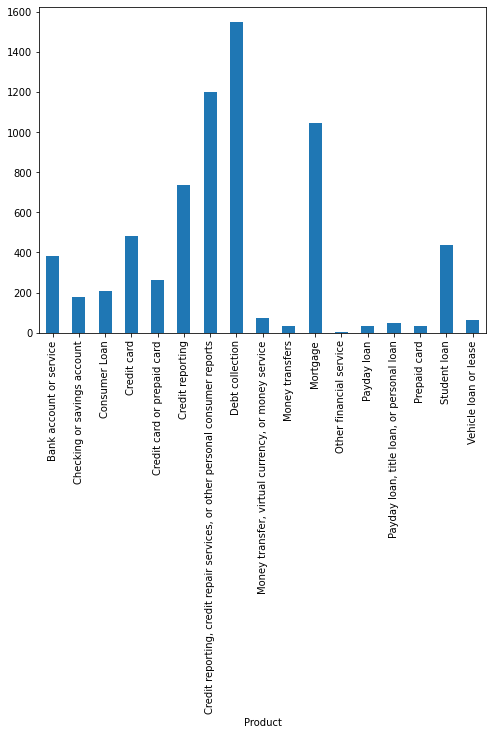

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
# latin-1 is a single-byte encoding which uses the characters 0 through 127, so it can encode half as many characters as latin1. 
# It's a strict subset of both latin1 and utf8, meaning the bytes 0 through 127 in both latin1 and utf8 encode the same things as they do in ASCII
features = tfidf.fit_transform(df.Consumer_Complaint).toarray()
labels = df.category_id
features.shape

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigram:\n. {}".format('\n. '.join(trigrams[-N:])))